### Note
Perhaps it is best to link a google drive storage to this notebook. Downloading the model weights is time consuming and I'm afraid we may hit the colab disk threshold.

In [ ]:
!git clone https://github.com/halixness/point-e
%cd point-e/

Cloning into 'point-e'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 107 (delta 29), reused 43 (delta 17), pack-reused 31
Receiving objects: 100% (107/107), 4.20 MiB | 28.66 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/point-e


In [ ]:
!pip install -e .
!pip install diffusers transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-grzjwjpt/clip_7fd4ae4ce3a742118a7c9bd29f6a0a7a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-grzjwjpt/clip_7fd4ae4ce3a742118a7c9bd29f6a0a7a
  Resolved https://github.com/openai/CLIP.git to commit 3702849800aa56e2223035bccd1c6ef91c704ca8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 2.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=4c85981e39fbabae83dd4ac07d684648cc3f5f43a9fba3d710f00fe1845c79ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-cychucnz/wheels/ab/4f/3a/

In [ ]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
img_size = 512
border = 100
background_color = 255

# Starting image is a square on white bg
booth = np.ones((img_size, img_size,3))*background_color
booth[border:img_size-border,border:img_size-border,:] = 0
booth = Image.fromarray(booth.astype(np.uint8()))

mask = np.zeros((img_size,img_size,3))
mask[border:img_size-border,border:img_size-border,:] = 255
mask = Image.fromarray(mask.astype(np.uint8()))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

prompt = "a blue coffee mug"
prompt_details = ", full body centered camera view, blender render, high resolution, standard light, no reflections"

generated_image = pipe(prompt=prompt + prompt_details, image=booth, mask_image=mask).images[0]

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/308 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/460 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/914 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/616 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

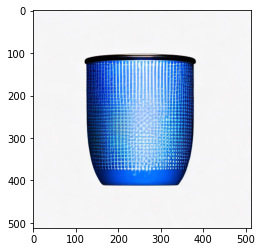

In [ ]:
plt.imshow(generated_image)

In [ ]:
PILtoTensor = transforms.ToTensor()
torch.cuda.empty_cache()
del pipe

In [ ]:
base_name = 'base1B' # base40M, use base300M or base1B for better results
n_points = 1024
final_n_points = 4096
MODEL_CONFIGS[base_name]["n_ctx"] = n_points
MODEL_CONFIGS["upsample"]["n_ctx"] = final_n_points - n_points

print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|███████████████████████████████████████| 890M/890M [00:27<00:00, 34.3MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/4.98G [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[n_points, final_n_points - n_points], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [ ]:
# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[generated_image]))):
    samples = x

0it [00:00, ?it/s]

In [ ]:
samples.shape

torch.Size([1, 6, 4096])

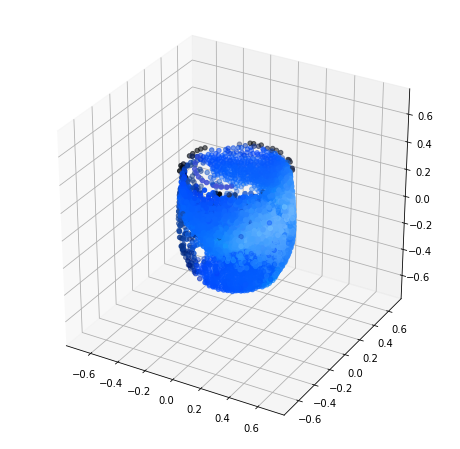

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

### pointcloud-to-mesh

In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

In [ ]:
# Signed distance field model
print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


  0%|          | 0.00/38.0M [00:00<?, ?iB/s]

<All keys matched successfully>

In [ ]:
import skimage.measure
skimage.measure.label

# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=128, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/178 [00:00<?, ?it/s]

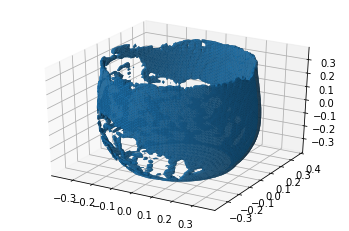

In [ ]:
# Write the mesh to a PLY file to import into some other program.
# with open('mesh.ply', 'wb') as f:
#    mesh.write_ply(f)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(mesh.verts[:, 0], mesh.verts[:,1], triangles=mesh.faces, Z=mesh.verts[:,2]) 
plt.show()